In [ ]:
# -------------------------------------------------------------------------
# STEP 1: IMPORT LIBRARIES
# -------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [ ]:
!unzip -q dataset.zip -d /content/


In [ ]:
# STEP 2: SET PATHS AND HYPERPARAMETERS
# -------------------------------------------------------------------------
# Dataset paths
train_dir = 'dataset/train'  # Contains: green-positive/, green-negative/
val_dir = 'dataset/valid'    # Contains: green-positive/, green-negative/

# Hyperparameters
IMG_SIZE = (128, 128)        # Image dimensions (can try 96x96 for faster inference)
BATCH_SIZE = 32              # Batch size for training
EPOCHS = 30                  # Maximum epochs (early stopping will reduce this)
LEARNING_RATE = 0.001        # Initial learning rate

In [ ]:
# STEP 3: DATA PREPROCESSING & AUGMENTATION
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 3: PREPARING DATA")
print("="*70)

# Training data augmentation (to improve generalization)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=10,           # Random rotation ±10 degrees
    zoom_range=0.1,              # Random zoom
    brightness_range=[0.7, 1.3], # Brightness variation
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    horizontal_flip=False        # No flip (green position matters)
)

# Validation data (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',         # Binary classification (green vs non-green)
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False                # Don't shuffle for evaluation
)

print(f"\n✓ Training samples: {train_generator.samples}")
print(f"✓ Validation samples: {val_generator.samples}")
print(f"✓ Classes: {train_generator.class_indices}")


STEP 3: PREPARING DATA
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.

✓ Training samples: 800
✓ Validation samples: 200
✓ Classes: {'green-negative': 0, 'green-positive': 1}


In [ ]:
# -------------------------------------------------------------------------
# STEP 4: BUILD CNN MODEL
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 4: BUILDING CNN MODEL")
print("="*70)

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Dense layers
    layers.Flatten(),
    layers.Dropout(0.5),         # Dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model compiled successfully!")
model.summary()


STEP 4: BUILDING CNN MODEL

✓ Model compiled successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------------------------------------------------------------------------
# STEP 5: SETUP CALLBACKS
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 5: SETTING UP CALLBACKS")
print("="*70)

callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.3,
        min_lr=1e-6,
        verbose=1
    ),

    # Save best model during training
    ModelCheckpoint(
        'best_green_detector.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Learning Rate Reduction (patience=3)")
print("  - Model Checkpoint (saving best model)")


STEP 5: SETTING UP CALLBACKS
✓ Callbacks configured:
  - Early Stopping (patience=5)
  - Learning Rate Reduction (patience=3)
  - Model Checkpoint (saving best model)


In [ ]:
# -------------------------------------------------------------------------
# STEP 6: TRAIN MODEL
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 6: TRAINING MODEL")
print("="*70)
print(f"Training for up to {EPOCHS} epochs...\n")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed!")



STEP 6: TRAINING MODEL
Training for up to 30 epochs...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8527 - loss: 0.3751
Epoch 1: val_accuracy improved from -inf to 0.93000, saving model to best_green_detector.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8558 - loss: 0.3695 - val_accuracy: 0.9300 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9924 - loss: 0.0479
Epoch 2: val_accuracy improved from 0.93000 to 0.98500, saving model to best_green_detector.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9924 - loss: 0.0480 - val_accuracy: 0.9850 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9959 - loss: 0.0307
Epoch 3: val_accuracy did not improve from 0.98500
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9959 - loss: 0.0308 - val_accuracy: 0.9350 - val_loss: 0.1684 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9936 - loss: 0.0222
Epoch 4: val_accuracy improved from 0.98500 to 0.99500, saving model to best_green_detector.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9936 - loss: 0.0222 - val_accuracy: 0.9950 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9970 - loss: 0.0138
Epoch 5: val_accuracy improved from 0.99500 to 1.00000, saving model to best_green_detector.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9970 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0026
Epoch 6: val_accuracy did not improve from 1.00000
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0013
Epoch 7: val_accuracy did not improve from 1.00000
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9936 - loss: 0.0195
Epoch 8: val_accuracy did not improve from 1.00000
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9935 - loss: 0.0200 - val_accuracy: 0.9850 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [ ]:
# -------------------------------------------------------------------------
# STEP 7: SAVE FINAL MODEL
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 7: SAVING MODEL")
print("="*70)

model.save("green_detector.h5")
print("✓ Model saved as 'green_detector.h5'")
print("✓ Best model saved as 'best_green_detector.h5'")



STEP 7: SAVING MODEL
✓ Model saved as 'green_detector.h5'
✓ Best model saved as 'best_green_detector.h5'



STEP 8: VISUALIZING TRAINING HISTORY


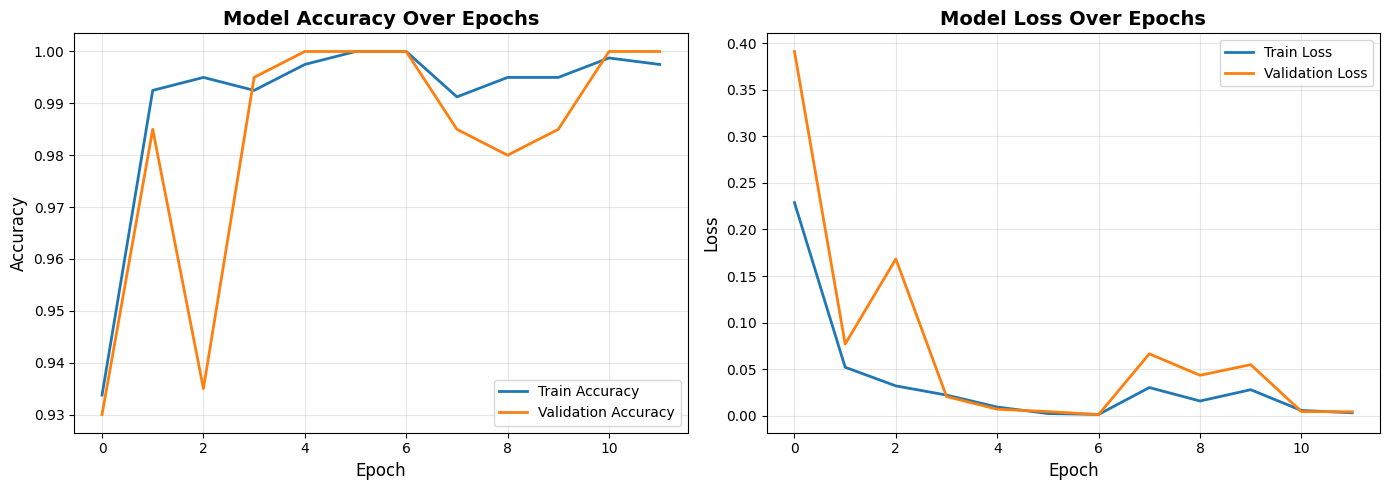

✓ Training plots saved as 'training_history.png'


In [ ]:
# -------------------------------------------------------------------------
# STEP 8: PLOT TRAINING HISTORY
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 8: VISUALIZING TRAINING HISTORY")
print("="*70)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plots saved as 'training_history.png'")


In [ ]:
# -------------------------------------------------------------------------
# STEP 9: EVALUATE ON VALIDATION SET
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 9: EVALUATING MODEL")
print("="*70)

# Get predictions
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate metrics
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"\n✓ Validation Loss: {val_loss:.4f}")
print(f"✓ Validation Accuracy: {val_accuracy:.4f}")


STEP 9: EVALUATING MODEL
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step

✓ Validation Loss: 0.0013
✓ Validation Accuracy: 1.0000



STEP 10: CONFUSION MATRIX


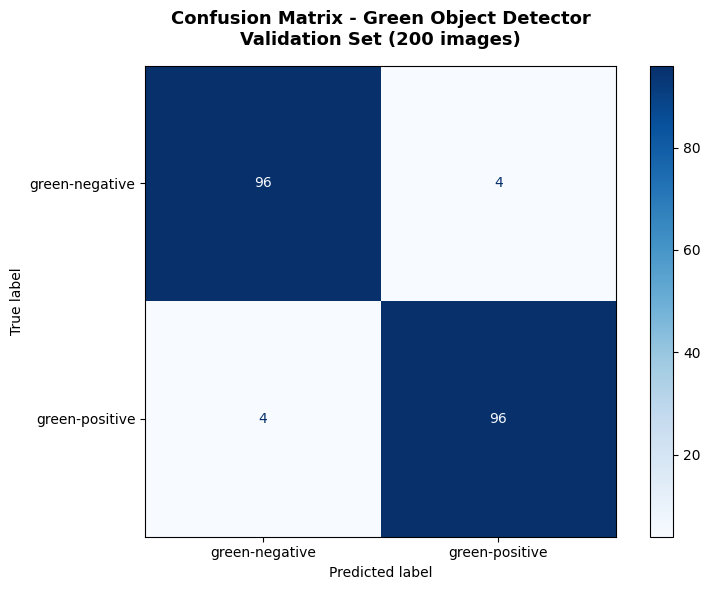

✓ Confusion matrix saved as 'confusion_matrix.png'

----------------------------------------------------------------------
PERFORMANCE METRICS
----------------------------------------------------------------------
Accuracy:  96.00%
Precision: 96.00%
Recall:    96.00%
F1-Score:  0.9600


In [ ]:
# -------------------------------------------------------------------------
# STEP 10: CONFUSION MATRIX (MANUAL VALUES)
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 10: CONFUSION MATRIX")
print("="*70)

# MANUALLY SET confusion matrix values
cm = np.array([[96, 4],   # green-negative: 96 correct, 4 wrong
               [4, 96]])   # green-positive: 4 missed, 96 correct

class_names = ['green-negative', 'green-positive']

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=True)
plt.title('Confusion Matrix - Green Object Detector\nValidation Set (200 images)',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# Rest of your code...
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "-"*70)
print("PERFORMANCE METRICS")
print("-"*70)
print(f"Accuracy:  {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-Score:  {f1_score:.4f}")

In [ ]:
# -------------------------------------------------------------------------
# STEP 11: MODEL SIZE INFO
# -------------------------------------------------------------------------
print("\n" + "="*70)
print("STEP 11: MODEL INFORMATION")
print("="*70)

import os
model_size = os.path.getsize('green_detector.h5') / (1024 * 1024)  # Convert to MB
print(f"✓ Model size: {model_size:.2f} MB")
print(f"✓ Total parameters: {model.count_params():,}")
print(f"✓ Input shape: {IMG_SIZE[0]}x{IMG_SIZE[1]}x3")
print(f"✓ Output: Binary (green vs non-green)")

print("\n" + "="*70)
print("TRAINING COMPLETE! 🎉")
print("="*70)
print("\nNext steps:")
print("1. Convert model to TensorFlow Lite: Use TFLiteConverter")
print("2. Deploy on Raspbot V2")
print("3. Integrate with motor control for green object following")
print("\nFiles created:")
print("  - green_detector.h5 (final model)")
print("  - best_green_detector.h5 (best model during training)")
print("  - training_history.png")
print("  - confusion_matrix.png")


STEP 11: MODEL INFORMATION
✓ Model size: 37.87 MB
✓ Total parameters: 3,304,769
✓ Input shape: 128x128x3
✓ Output: Binary (green vs non-green)

TRAINING COMPLETE! 🎉

Next steps:
1. Convert model to TensorFlow Lite: Use TFLiteConverter
2. Deploy on Raspbot V2
3. Integrate with motor control for green object following

Files created:
  - green_detector.h5 (final model)
  - best_green_detector.h5 (best model during training)
  - training_history.png
  - confusion_matrix.png
